In [78]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.figure_factory as ff
import plotly.graph_objects as go
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor

In [79]:
pd.options.display.max_columns = None

In [80]:
PATH = './data_tesco/'

GROCERY_WARD = 'year_osward_grocery.csv'
GROCERY_BOROUGH = 'year_borough_grocery.csv'

DIABETES_WARD = 'diabetes_estimates_osward_2016.csv'
OBESITY_BOROUGH = 'london_obesity_borough_2012.csv'
OBESITY_HOSP_BOROUGH = 'obesity_hospitalization_borough_2016.csv'
CHILD_OBESITY_WARD = 'child_obesity_london_ward_2013-2014.csv'

In [81]:
groceries_borough = pd.read_csv(PATH + GROCERY_BOROUGH, sep = ',', header = 0)
groceries_ward = pd.read_csv(PATH + GROCERY_WARD, sep = ',', header = 0)

In [82]:
diabetes_ward = pd.read_csv(DATA_PATH + DIABETES_WARD, sep = ',', header = 0)
obesity_borough = pd.read_csv(DATA_PATH + OBESITY_BOROUGH, sep = ',', header = 0)
obesity_hosp_borough = pd.read_csv(DATA_PATH + OBESITY_HOSP_BOROUGH, sep = ',', header = 0)
child_obesity_ward = pd.read_csv(DATA_PATH + CHILD_OBESITY_WARD, sep = ',', header = 0)

In [83]:
diabetes_ward.head()

area_id  gp_patients  gp_patients_diabetes  estimated_diabetes_prevalence
0  E05000026        13136                  1068                            8.1
1  E05000027         8954                   631                            7.0
2  E05000028        12032                   958                            8.0
3  E05000029         8853                   700                            7.9
4  E05000030         8813                   640                            7.3

In [84]:
obesity_borough.head()

oslaua  f_healthy_weight  f_overweight  f_obese  weighted_sample
0  E09000001              36.5          30.5     31.4               20
1  E09000002              33.4          31.9     31.6              409
2  E09000003              42.1          35.2     20.5              862
3  E09000004              33.5          43.1     23.0              589
4  E09000005              43.9          34.9     19.5              712

In [85]:
to_drop = obesity_hosp_borough[obesity_hosp_borough['total_hospitalizations'] == 'na' ].index
obesity_hosp_borough.drop(to_drop , inplace=True)
obesity_hosp_borough.head()

area_id total_hospitalizations total_bariatric  \
1  E09000002                     34              25   
2  E09000003                     94              61   
3  E09000004                     82              51   
4  E09000005                    105              70   
5  E09000006                     60              39   

  prevalence_hospitalizations prevalence_bariatric  
1                       0.018                0.014  
2                       0.026                0.017  
3                       0.035                0.022  
4                       0.036                0.022  
5                       0.018                0.012

In [86]:
to_drop = child_obesity_ward[ (child_obesity_ward['prevalence_overweight_reception'] == 'na')
                             | (child_obesity_ward['prevalence_overweight_y6'] == 'na')
                            | (child_obesity_ward['prevalence_obese_reception'] == 'na')
                            | (child_obesity_ward['prevalence_obese_y6'] == 'na')].index
child_obesity_ward.drop(to_drop , inplace=True)
child_obesity_ward.head()

area_id number_reception_measured number_y6_measured  \
0  E05000026                       712                441   
1  E05000027                       592                427   
2  E05000028                       665                499   
3  E05000029                       484                362   
4  E05000030                       446                320   

  prevalence_overweight_reception prevalence_overweight_y6  \
0                     0.259831461              0.387755102   
1                     0.224662162              0.402810304   
2                      0.24962406              0.466933868   
3                     0.241735537              0.422651934   
4                     0.257847534                 0.378125   

  prevalence_obese_reception prevalence_obese_y6  
0                0.133426966         0.247165533  
1                0.099662162         0.259953162  
2                0.123308271          0.29258517  
3                0.128099174         0.245856354  
4                0.125560538            0.215625

In [87]:
merged = pd.merge(diabetes_ward, groceries_ward, how = 'inner', left_index = False, on='area_id')
merged_ward = pd.merge(merged, child_obesity_ward, how = 'inner', left_index = False, on='area_id')
merged_ward.head()

area_id  gp_patients  gp_patients_diabetes  \
0  E05000026        13136                  1068   
1  E05000027         8954                   631   
2  E05000028        12032                   958   
3  E05000029         8853                   700   
4  E05000030         8813                   640   

   estimated_diabetes_prevalence      weight  weight_perc2.5  weight_perc25  \
0                            8.1  449.535137            32.5          166.4   
1                            7.0  413.130263            32.5          150.0   
2                            8.0  407.100472            32.5          160.0   
3                            7.9  384.173858            30.0          150.0   
4                            7.3  356.882607            30.0          140.0   

   weight_perc50  weight_perc75  weight_perc97.5  weight_std  weight_ci95  \
0          300.0          500.0           1500.0  771.349423     3.716832   
1          300.0          500.0           1500.0  626.395178     5.164174   
2          300.0          500.0           1200.0  545.890959     2.710677   
3          250.0          454.0           1500.0  591.837557     4.968373   
4          250.0          450.0           1000.0  465.284180     3.880963   

       volume  volume_perc2.5  volume_perc25  volume_perc50  volume_perc75  \
0  125.960833           11.00         45.000           90.0          200.0   
1  110.664114           15.00         40.000           75.0          150.0   
2  121.990710           11.00         45.000           90.0          175.0   
3  122.245578           11.00         46.875           90.0          175.0   
4  109.959688           13.69         45.500           75.0          132.0   

   volume_perc97.5  volume_std  volume_ci95       fat  fat_perc2.5  \
0            340.8  114.892118     1.127239  9.488797          0.0   
1            340.8  106.263796     1.918890  9.733634          0.0   
2            340.8  118.174981     1.270970  9.216310          0.0   
3            340.8  121.402651     2.135811  9.700137          0.0   
4            340.8  108.327264     2.036758  9.381808          0.0   

   fat_perc25  fat_perc50  fat_perc75  fat_perc97.5    fat_std  fat_ci95  \
0         0.2         2.4        14.1          50.5  15.119655  0.057529   
1         0.2         2.4        14.4          51.0  15.595896  0.102111   
2         0.2         2.5        14.0          47.1  14.302135  0.056960   
3         0.2         2.5        15.8          46.7  14.570747  0.096436   
4         0.2         2.6        14.6          46.4  13.977789  0.092451   

   saturate  saturate_perc2.5  saturate_perc25  saturate_perc50  \
0  3.693721               0.0              0.1              0.8   
1  3.565913               0.0              0.1              0.8   
2  3.613582               0.0              0.1              0.8   
3  3.961264               0.0              0.1              0.8   
4  3.614663               0.0              0.1              0.9   

   saturate_perc75  saturate_perc97.5  saturate_std  saturate_ci95      salt  \
0              4.3               21.0      6.714925       0.025550  0.583240   
1              4.1               20.0      6.323772       0.041404  0.568184   
2              4.2               20.0      6.439851       0.025648  0.610536   
3              5.1               20.5      6.895349       0.045637  0.533180   
4              4.4               20.0      6.329269       0.041863  0.566784   

   salt_perc2.5  salt_perc25  salt_perc50  salt_perc75  salt_perc97.5  \
0           0.0         0.01         0.20         0.80            2.4   
1           0.0         0.01         0.20         0.80            2.4   
2           0.0         0.03         0.21         0.80            2.4   
3           0.0         0.01         0.20         0.79            2.2   
4           0.0         0.03         0.21         0.80            2.2   

   salt_std  salt_ci95      sugar  sugar_perc2.5  sugar_perc25  sugar_perc50  \
0  2.23942

In [88]:
merged = pd.merge(obesity_hosp_borough, groceries_borough, how = 'inner', left_index = False,
                  on='area_id')
merged_borough = pd.merge(merged, obesity_borough, how = 'inner', left_index = False, left_on='area_id',
                         right_on = 'oslaua')
merged_borough.head()

area_id total_hospitalizations total_bariatric  \
0  E09000002                     34              25   
1  E09000003                     94              61   
2  E09000004                     82              51   
3  E09000005                    105              70   
4  E09000006                     60              39   

  prevalence_hospitalizations prevalence_bariatric      weight  \
0                       0.018                0.014  421.304125   
1                       0.026                0.017  407.170491   
2                       0.035                0.022  359.544126   
3                       0.036                0.022  434.324141   
4                       0.018                0.012  319.336273   

   weight_perc2.5  weight_perc25  weight_perc50  weight_perc75  \
0            32.5          165.6          300.0          500.0   
1            40.0          180.0          320.0          500.0   
2            30.0          144.0          255.0          450.0   
3            40.0          175.0          325.0          500.0   
4            30.0          135.0          250.0          400.0   

   weight_perc97.5  weight_std  weight_ci95      volume  volume_perc2.5  \
0           1500.0  597.994271     0.828993  122.341294            11.0   
1           1160.0  443.644324     0.171615  114.933771            10.1   
2           1000.0  476.576945     0.819748  106.446426            11.0   
3           1500.0  616.087316     0.354492  128.930369            11.0   
4           1000.0  347.979651     0.458224  101.105159            12.5   

   volume_perc25  volume_perc50  volume_perc75  volume_perc97.5  volume_std  \
0           47.1           90.0          175.0            340.8  115.859833   
1           50.0           75.0          160.0            340.8  102.318670   
2           44.0           75.0          132.0            340.8  101.662713   
3           50.0          100.0          200.0            340.8  111.360311   
4           47.3           75.0          113.6            340.8   88.178240   

   volume_ci95       fat  fat_perc2.5  fat_perc25  fat_perc50  fat_perc75  \
0     0.351870  9.209959          0.0         0.2         2.4        13.9   
1     0.088928  8.594464          0.0         0.2         1.8        12.0   
2     0.401246  9.119180          0.0         0.2         2.4        13.9   
3     0.134100  8.962466          0.0         0.2         2.0        13.0   
4     0.243147  9.123054          0.0         0.2         2.3        14.2   

   fat_perc97.5    fat_std  fat_ci95  saturate  saturate_perc2.5  \
0          48.2  14.478662  0.016131  3.596834               0.0   
1          50.5  14.594997  0.004558  3.407353               0.0   
2          45.8  13.995809  0.019506  3.466346               0.0   
3          50.5  14.806922  0.006800  3.559913               0.0   
4          44.8  13.726369  0.014451  3.556924               0.0   

   saturate_perc25  saturate_perc50  saturate_perc75  saturate_perc97.5  \
0              0.1              0.8              4.1               20.5   
1              0.1              0.4              3.4               21.5   
2              0.1              0.8              3.9               19.6   
3              0.1              0.6              3.8               21.4   
4              0.1              0.8              4.1               20.0   

   saturate_std  saturate_ci95      salt  salt_perc2.5  salt_perc25  \
0      6.466539       0.007205  0.603081           0.0         0.03   
1      6.770946       0.002114  0.567211           0.0         0.01   
2      6.280437       0.008753  0.591326           0.0         0.03   
3      6.802470       0.003124  0.570477           0.0         0.01   
4      6.286297       0.006618  0.563583           0.0         0.01   

   salt_perc50  salt_perc75  salt_perc97.5  salt_std  salt_ci95      sugar  \
0         0.20         0.80            2.4  2.168270   0.002416  10.793244   
1         0.11         0.72            2.5  2.55

### Visualize data

Plot nutrient and category repartition in average diet

In [89]:
f_nutrients = ['f_energy_fat', 'f_energy_saturate', 'f_energy_sugar', 'f_energy_protein', 'f_energy_carb', 'f_energy_fibre',
            'f_energy_alcohol']
f_food_categories = ['f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains',
                   'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits',
                   'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine']
features = f_nutrients + f_food_categories

In [90]:
average_nutrients = pd.DataFrame(groceries_ward.mean(axis = 0)[f_nutrients], columns = ['nutrient'])
average_categories = pd.DataFrame(groceries_ward.mean(axis = 0)[f_food_categories], columns = ['category'])

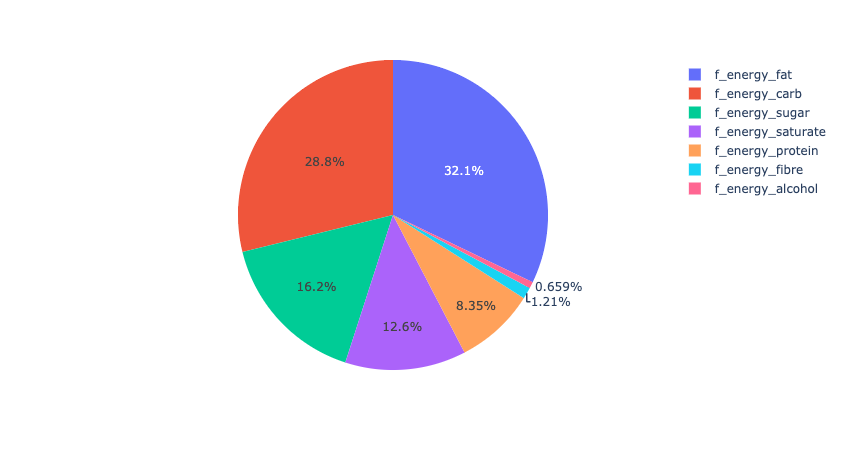

In [91]:
fig = px.pie(data_frame = average_nutrients, values = 'nutrient', names = average_nutrients.index)
fig.show()

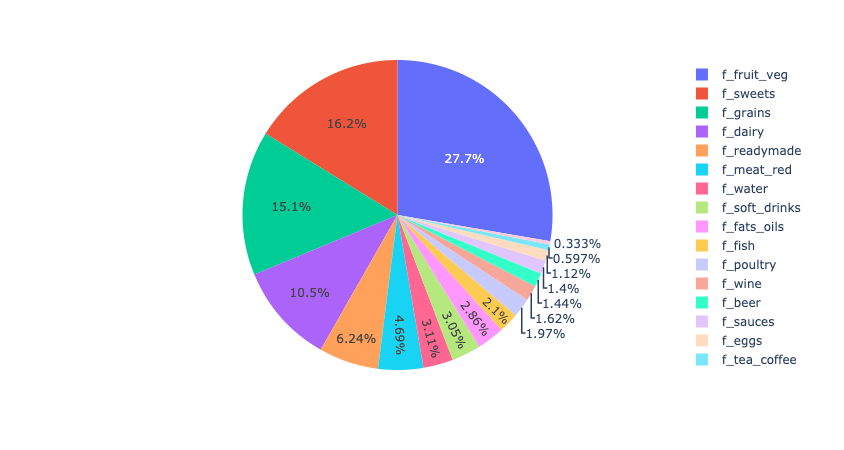

In [92]:
fig = px.pie(data_frame = average_categories, values = 'category', names = average_categories.index)
fig.show()

### Compute diet score

Method 1 : use correlation coefficients with diabetes and obesity

In [94]:
correlation = pd.DataFrame(columns = ['feature', 'R', 'p_value'])
for f in features:
    corr = stats.spearmanr(merged_diabetes['estimated_diabetes_prevalence'],merged_diabetes[f])
    corr_data = pd.DataFrame([[f, corr[0], corr[1]]], columns = ['feature', 'R', 'p_value'])
    correlation = correlation.append(corr_data, ignore_index = True)
sig_features = correlation[correlation['p_value'] < 1e-3]

In [95]:
def score(area):
    #features = ['energy_tot', 'energy_fat', 'energy_saturate', 'energy_sugar',
            #'energy_protein', 'energy_carb', 'energy_fibre', 'h_nutrients_calories']
    f = sig_features['feature'].values
    df = area[f].values
    weights = sig_features[['R']].values

    score = (df*weights).sum()
    #for i, f in enumerate(features):
        #score += df[0]*correlation.loc[correlation['feature'] == f]['R']
    return score

In [96]:
groceries_borough['score'] = groceries_borough.apply(score, axis=1)
scaler = MinMaxScaler()
groceries_borough['score'] = scaler.fit_transform(groceries_borough[['score']].values.reshape(-1,1))

Check consistency : plot repartition of lowest and highest scoring area

In [97]:
lowest = pd.DataFrame(groceries_borough[groceries_borough['score'] == 1][sig_features['feature'].values]).T
lowest.columns = ['nutrient']
highest = pd.DataFrame(groceries_borough[groceries_borough['score'] == 0][sig_features['feature'].values]).T
highest.columns = ['nutrient']

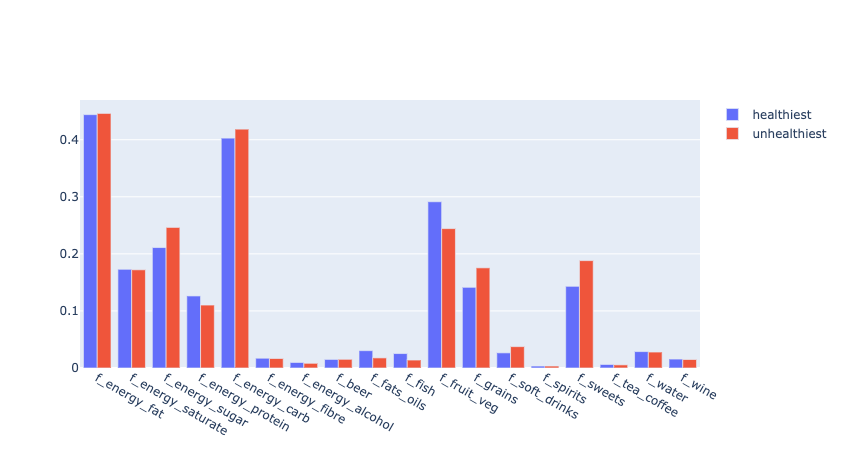

In [98]:
fig = go.Figure(data=[
    go.Bar(name='healthiest', x= lowest.index, y=lowest['nutrient']),
    go.Bar(name='unhealthiest', x= highest.index, y= highest['nutrient'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

Method 2 : fit a linear regression between features and several nutrition-related diseases and average the weights to compute the score

In [52]:
def find_weights(merged, label):
    X = merged[features]
    y = merged[label]
    model = SGDRegressor()
    model.fit(X,y)
    return model.coef_

In [73]:
validation_ward = ['estimated_diabetes_prevalence', 'prevalence_obese_reception', 'prevalence_obese_y6']
validation_borough = ['f_obese']

In [75]:
weights = pd.DataFrame(columns = validation_ward + validation_borough)
for label in validation_ward:
    weights[label] = find_weights(merged_ward, label)

for label in validation_borough:
    weights[label] = find_weights(merged_borough, label)

weights.index = features
weights['average'] = weights.mean(axis = 1)
weights

estimated_diabetes_prevalence  prevalence_obese_reception  \
f_energy_fat                            1.498695                    0.028428   
f_energy_saturate                       0.645993                    0.011121   
f_energy_sugar                          1.199269                    0.014467   
f_energy_protein                        0.103884                    0.007241   
f_energy_carb                           2.331040                    0.026586   
f_energy_fibre                          0.017968                    0.000992   
f_energy_alcohol                       -0.052787                    0.000462   
f_beer                                 -0.092017                    0.000659   
f_dairy                                 0.519010                    0.006880   
f_eggs                                  0.035154                    0.000826   
f_fats_oils                             0.221608                    0.002179   
f_fish                                 -0.050721                    0.001422   
f_fruit_veg                            -0.127567                    0.016142   
f_grains                                1.115072                    0.009781   
f_meat_red                              0.085349                    0.003308   
f_poultry                               0.033395                    0.001344   
f_readymade                             0.142304                    0.003126   
f_sauces                                0.045885                    0.000943   
f_soft_drinks                           0.396132                    0.002426   
f_spirits                               0.040834                    0.000265   
f_sweets                                1.362354                    0.010754   
f_tea_coffee                            0.032944                    0.000425   
f_water                                 0.394946                    0.002727   
f_wine                                 -0.255882                    0.000501   

                   prevalence_obese_y6   f_obese   average  
f_energy_fat                  0.060678  5.381645  1.742362  
f_energy_saturate             0.023816  2.107830  0.697190  
f_energy_sugar                0.030418  2.813831  1.014496  
f_energy_protein              0.015418  1.384198  0.377685  
f_energy_carb                 0.055478  5.086831  1.874984  
f_energy_fibre                0.002118  0.197413  0.054623  
f_energy_alcohol              0.001063  0.100142  0.012220  
f_beer                        0.001541  0.155661  0.016461  
f_dairy                       0.014824  1.225456  0.441543  
f_eggs                        0.001776  0.127822  0.041394  
f_fats_oils                   0.004589  0.350882  0.144815  
f_fish                        0.003012  0.227852  0.045391  
f_fruit_veg                   0.034549  3.098823  0.755486  
f_grains                      0.020343  1.933076  0.769568  
f_meat_red                    0.006922  0.608141  0.175930  
f_poultry                     0.002834  0.250306  0.071970  
f_readymade                   0.006528  0.808634  0.240148  
f_sauces                      0.002007  0.182856  0.057923  
f_soft_drinks                 0.005090  0.410413  0.203515  
f_spirits                     0.000556  0.042643  0.021074  
f_sweets                      0.022387  2.090540  0.871509  
f_tea_coffee                  0.000869  0.075970  0.027552  
f_water                       0.005607  0.407720  0.202750  
f_wine                        0.001325  0.153434 -0.025155

In [76]:
def score1(area):

    df = area[features].values
    w = weights['average'].values

    score = (df*w).sum()
    return score
groceries_borough['score'] = groceries_borough.apply(score1, axis=1)
scaler = MinMaxScaler()
groceries_borough['score'] = scaler.fit_transform(groceries_borough[['score']].values.reshape(-1,1))

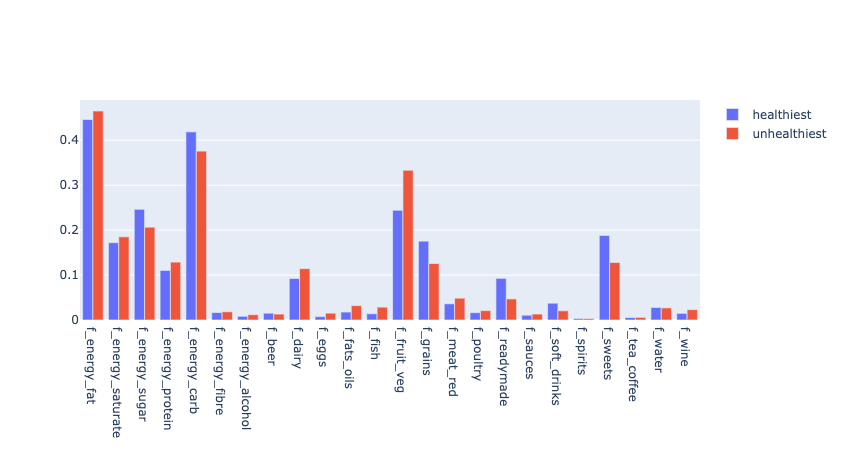

In [77]:
lowest = pd.DataFrame(groceries_borough[groceries_borough['score'] == 1][features]).T
lowest.columns = ['nutrient']
highest = pd.DataFrame(groceries_borough[groceries_borough['score'] == 0][features]).T
highest.columns = ['nutrient']
fig = go.Figure(data=[
    go.Bar(name='healthiest', x= lowest.index, y=lowest['nutrient']),
    go.Bar(name='unhealthiest', x= highest.index, y= highest['nutrient'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

### Map viz

In [99]:
borough = 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
map_borough = gpd.read_file(borough)
merged = map_borough.merge(groceries_borough, left_on = 'GSS_CODE', right_on = 'area_id', how = 'inner')

In [100]:
merged.head()

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry    area_id  \
0     None  POLYGON ((516401.600 160201.800, 516407.300 16...  E09000021   
1     None  POLYGON ((535009.200 159504.700, 535005.500 15...  E09000008   
2     None  POLYGON ((540373.600 157530.400, 540361.200 15...  E09000006   
3     None  POLYGON ((521975.800 178100.000, 521967.700 17...  E09000018   
4     None  POLYGON ((510253.500 182881.600, 510249.900 18...  E09000009   

       weight  weight_perc2.5  weight_perc25  weight_perc50  weight_perc75  \
0  297.379174            30.0          125.0          220.0          400.0   
1  353.636123            30.0          150.0          250.0          450.0   
2  319.336273            30.0          135.0          250.0          400.0   
3  336.922944            32.5          150.0          250.0          450.0   
4  358.569245            35.0          154.0          275.0          454.0   

   weight_perc97.5  weight_std  weight_ci95      volume  volume_perc2.5  \
0           1000.0  318.095793     0.996035   95.006632            15.0   
1           1000.0  425.267620     0.487412  107.461977            12.5   
2           1000.0  347.979651     0.458224  101.105159            12.5   
3           1000.0  359.841786     0.635360  105.201811            15.0   
4           1000.0  373.797449     0.271506  106.197369            11.0   

   volume_perc25  volume_perc50  volume_perc75  volume_perc97.5  volume_std  \
0           44.0           75.0          113.6            340.8   84.699759   
1           44.0           75.0          150.0            340.8   94.587924   
2           47.3           75.0          113.6            340.8   88.178240   
3           47.5           75.0          113.6            340.8   93.663311   
4           50.0           75.0          113.6            340.8   91.097031   

   volume_ci95       fat  fat_perc2.5  fat_perc25  fat_perc50  fat_perc75  \
0     0.583033  9.293907          0.0         0.2         2.5        14.6   
1     0.226020  9.093330          0.0         0.2         2.3        14.0   
2     0.243147  9.123054          0.0         0.2         2.3        14.2   
3     0.364225  9.263181          0.0         0.2         2.2        14.2   
4     0.145025  9.012152          0.0         0.3         2.0        13.3   

   fat_perc97.5    fat_std  fat_ci95  saturate  saturate_perc2.5  \
0          45.0  13.633114  0.034063  3.562829               0.0   
1          46.4  13.991185  0.012827  3.529783               0.0   
2          44.8  13.726369  0.014451  3.556924               0.0   
3          47.0  14.101003  0.019932  3.653929               0.0   
4          48.3  14.382954  0.008423  3.588559               0.0   

   saturate_perc25  saturate_perc50  saturate_perc75  saturate_perc97.5  \
0              0.1              0.8              4.0               20.0   
1              0.1              0.8              4.1               20.0   
2              0.1              0.8              4.1               20.0   
3              0.1              0.7              4.1               21.0   
4              0.1              0.6              3.8               21.6   

   saturate_std  saturate_ci95      salt  salt_perc2.5  salt_perc25  \
0      6.339672       0.015840  0.568681           0.0         0.01   
1      6.357896       0.005829  0.567815           0.0         0.01   
2      6.286297       0.006618  0.563583           0.0         0.01   
3      6.592520       0.009319  0.577265           0.0         0.01   
4      6

In [101]:
merged = merged.to_crs(epsg=4326) # convert the coordinate reference system to lat/long
lga_json = merged.__geo_interface__ #covert to geoJSON

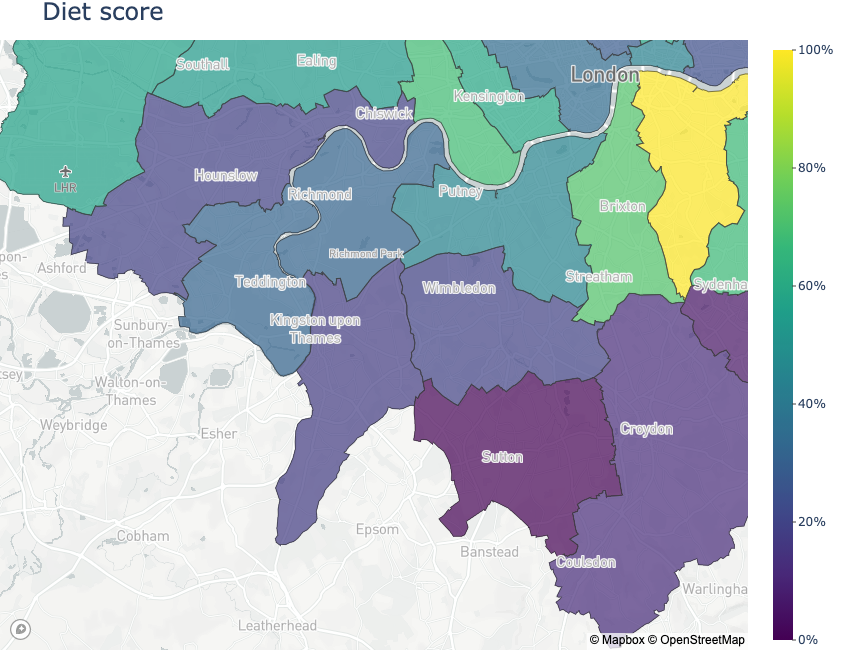

In [37]:
MAPBOX_ACCESSTOKEN = 'pk.eyJ1Ijoic29zbzk0IiwiYSI6ImNraTdwem80MDFsNXEyc3FzeGMxOHpoZGkifQ.coIFQU-pN6pZJi0GuXnLVw'

zmin = merged['score'].min()
zmax = merged['score'].max()
name = merged['NAME']

# Set the data for the map
data = go.Choroplethmapbox(
        geojson = lga_json,             #this is your GeoJSON
        locations = merged.index,    #the index of this dataframe should align with the 'id' element in your geojson
        z = merged.score, #sets the color value
        text = merged.NAME,    #sets text for each shape
        colorbar=dict(thickness=20, ticklen=3, tickformat='%',outlinewidth=0), #adjusts the format of the colorbar
        marker_line_width=1, marker_opacity=0.7, colorscale="Viridis", #adjust format of the plot
        zmin=zmin, zmax=zmax,           #sets min and max of the colorbar
        hovertemplate = "<b>%{text}</b><br>" +
                    "%{z:.0%}<br>" +
                    "<extra></extra>")  # sets the format of the text shown when you hover over each shape

# Set the layout for the map
layout = go.Layout(
    title = {'text': f"Diet score",
            'font': {'size':24}},       #format the plot title
    mapbox1 = dict(
        domain = {'x': [0, 1],'y': [0, 1]}, 
        center = dict(lat=51.509865 , lon=-0.118092),
        accesstoken = MAPBOX_ACCESSTOKEN, 
        zoom = 8),                      
    autosize=True,
    height=650,
    margin=dict(l=0, r=0, t=40, b=0))

# Generate the map
fig=go.Figure(data=data, layout=layout)
fig.show()